In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.layers import Conv2D,Dense,Dropout,Flatten,Input,MaxPooling2D,Reshape,UpSampling2D
from keras.models import Model

Using TensorFlow backend.


In [2]:
# Constants
IMG_ROWS, IMG_COLS = 28, 28
INPUT_SHAPE = (IMG_ROWS,IMG_COLS,1)
BATCH_SIZE = 400
EPOCHS = 200
CHECKPOINTS_PATH = 'checkpoints/'
CHECKPOINTS_NAME = 'cae.hdf5'

In [3]:
# Functions definition
def load_mnist():
    (images_train, labels_train) , (images_test,labels_test) = mnist.load_data()
    images_train = (images_train.astype('float32') / 255.).reshape((len(images_train),28, 28, 1))
    images_test = (images_test.astype('float32') / 255.).reshape((len(images_test),28, 28, 1))
    return images_train, labels_train, images_test, labels_test

def use_checkpoints(path, file_name):
    if not os.path.isdir(path):
        os.makedir(path)
    return ModelCheckpoint(path + file_name, monitor='loss', verbose=1, save_best_only=True, mode='auto')

In [4]:
# Load dataset
images_train, labels_train, images_test, labels_test = load_mnist()

In [5]:
# Create the model
input_img = Input(shape=(28,28,1))

# First convolutional layer and max pooling, output is 14x14x32
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

# Second convolutional layer and max pooling, output is 7x7x16
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Flatten to dim 786 and dense layer
x = Flatten()(x)
x = Dense(1960, activation='relu')(x)

# Encoded layer on a 2d space, linear activation
encoded = Dense(2, activation='linear')(x)

# Decoding layers
x = Dense(1960, activation='relu')(encoded)
x = Dense(784, activation='relu')(x)

x = Reshape((7,7,16))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [6]:
# Show the summary of the model
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1960)              1538600   
__________

In [7]:
# Train the model
autoencoder.fit(images_train,
                images_train,
                epochs=EPOCHS,
                batch_size=400,
                shuffle=True,
                verbose = 0,
                validation_split=0.33
                # callbacks=[use_checkpoints(CHECKPOINTS_PATH, CHECKPOINTS_NAME)]
               )

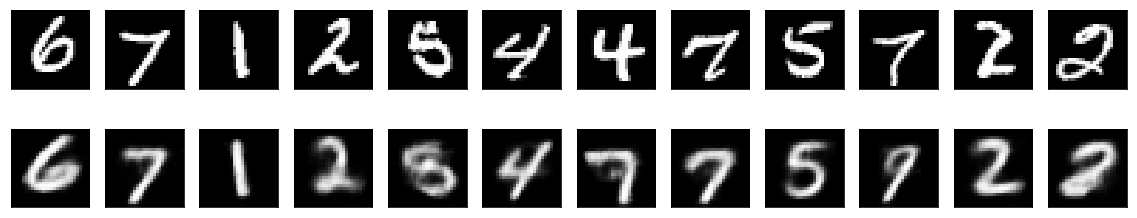

In [8]:
# Show some results of autoencoded images
N = 12

images_plot = images_test[np.random.randint(0,images_test.shape[0],N)]
autoencoded_imgs = autoencoder.predict(images_plot)

plt.figure(figsize=(20, 4))
for i in range(N):  
    # display original
    ax = plt.subplot(2, N, i + 1)
    plt.imshow(images_plot[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, N, i + 1 + N)
    plt.imshow(autoencoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

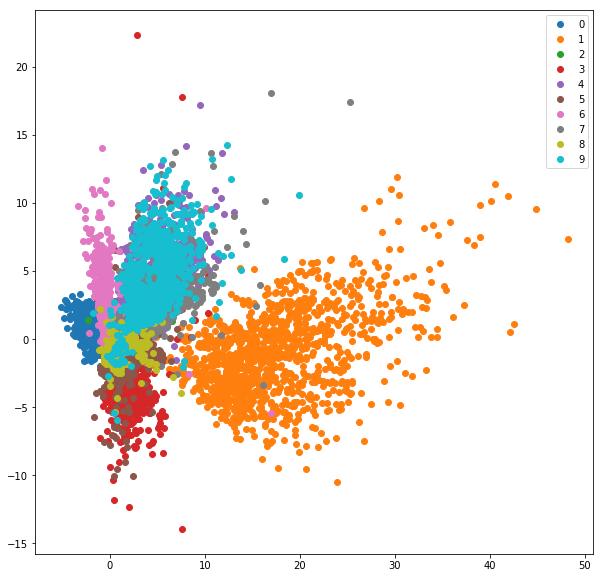

In [9]:
# Show the encoded test dataset in the 2d space
encoded_imgs = encoder.predict(images_test)
x = encoded_imgs[:,0]
y = encoded_imgs[:,1]

plt.figure(figsize=(10, 10))

for i in range(10):
    plt.plot(x[labels_test == i], y[labels_test == i], 'o');
plt.legend('0123456789')
plt.show()